# Disaster Tweets Using KerasNLP and Pretrained BERT

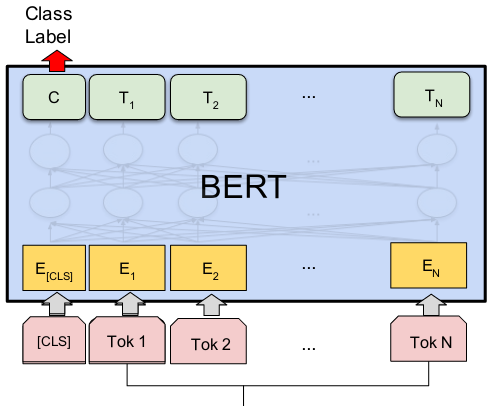

In [1]:
import os

In [2]:
IS_KAGGLE = os.path.exists('/kaggle/input')
print(IS_KAGGLE)

True


If this is being run in Kaggle then the dependencies will need to be installed directly into the image.

In [ ]:
if IS_KAGGLE:
    print("Installing additional libs")
    !pip install tensorflow==2.16.0
    !pip install numpy==1.26.1
    !pip install tweet-preprocessor
    !pip install keras-core --upgrade
    !pip install -q keras-nlp --upgrade

Installing additional libs
ERROR: Could not find a version that satisfies the requirement tensorflow==2.16 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.16
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 57.3 MB/s eta 0:00:00:00:0100:01


In [ ]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

## Lib Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

In [ ]:
from nltk.corpus import stopwords
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

ENGLISH_STOPWORDS = set(stopwords.words('english'))

# Local Helper Method Imports

Adding local path to sys path to add lib

In [ ]:
import sys
from pathlib import Path

current_path = Path.cwd()
print(f"current_path: {current_path}")
sys.path.append(current_path)

In [ ]:
#from disaster_tweet_helpers import preprocess_text

In [ ]:
import preprocessor as tweet_preprocessor
import string


def preprocess_text(text, stopwords):
    """_summary_

    Args:
        df (_type_): _description_
        column_name (_type_): _description_
        stopwords (_type_): _description_
    """
    def remove_punctuations(text: str):
        for punctuation in string.punctuation:
            text = text.replace(punctuation, '')
        return text

    text = text.lower()
    text = remove_punctuations(text)
    text = text.replace('\s\s+', ' ')
    text = tweet_preprocessor.clean(text)
    text = ' '.join([w for w in text.split(' ') if w not in stopwords])
    return text

# Constants

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
BATCH_SIZE = 32
Y_COLUMN = 'target'

## 1. Dataset Loading and Analysis

### 1.1 Train and Test Dataset Loading

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

In [ ]:
test_df.head()

### 1.2 EDA

In [ ]:
train_df['preprocessed_text'] = train_df['text'].apply(lambda x: preprocess_text(x, ENGLISH_STOPWORDS))
train_df.head()

In [ ]:
train_df['length'] = train_df['preprocessed_text'].apply(lambda x: len(x.split(' ')))
train_df.head()

In [ ]:
train_df['length'].hist(bins=20, figsize=(6, 6))

In [ ]:
train_df['length'].describe()

In [ ]:
X = train_df['preprocessed_text']
y = train_df[Y_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 2. Model Loading and Fine Tuning

In [ ]:
preset = 'distil_bert_base_en_uncased'
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, num_classes=2)
classifier.summary()

### 2.2 Model Fine Tuning

In [ ]:
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-5),
    metrics=['accuracy']
)

history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=2,
                         validation_data=(X_test, y_test),
                         verbose=True)